In [1]:
from visualizer import calibration

from PyQt5 import QtCore
import tifffile
from skimage.io import imread
from skimage.io.collection import alphanumeric_key
from dask import delayed
from glob import glob
import dask.array as da
import matplotlib.pyplot as plt
import numpy as np
import napari
from napari import Viewer
import os
import zarr
from skimage.registration import phase_cross_correlation
import cv2 as cv
from skimage import io
from skimage.morphology import skeletonize
from skan import Skeleton
import scipy.ndimage as ndi
import cupy as cp 
import waveorder as wo
from waveorder.io.multipagetiff import  MicromanagerOmeTiffReader
from aicsimageio import AICSImage,imread, imread_dask
import cv2 as cv
import analysis_utils as au
import bottleneck as bn
import pandas as pd

%gui qt 
%matplotlib inline
plt.style.use('dark_background')


from skimage.measure import find_contours

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [2]:
viewer = napari.Viewer()

# Scope Parameters
cam_px = 6.0e-6
totalmag = 15.75
zstep = 2e-6

px_size_img = cam_px/totalmag
z_scale = zstep/px_size_img

Assistant skips harvesting pyclesperanto as it's not installed.


c:\ProgramData\Anaconda3\envs\m25-py39\lib\site-packages\napari_tools_menu\__init__.py:168: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


In [3]:
### Enter the filepath for the data directory
main_dir =r'F:\DATA\20220507_M25_ZW495_9'   #5 fast dynamics of big worm
###Enter the filepath for background images
bg_dir = r'F:\Test_ignore\20220513_M25_bg_16bit'
### Enter the filepath for Calibration Dataset (PSF) or offset file
psf_dir = r'F:\Test_ignore\220508_190nmSteps_postitive2negative_1'
# psf_dir = r'F:\Test_ignore\220508_380nmSteps_minusplus_reversed_1'
#Get Folders and files
main_dirs = sorted(glob(main_dir + '/CAM*/'), key=alphanumeric_key)
bg_folders = sorted(glob(bg_dir + '/CAM*/'), key=alphanumeric_key)

# Load offsets from desired folder 
processed_files = main_dir + '/'+'processed_files'
if not os.path.exists(processed_files):
    os.makedirs(processed_files)

offset_dir = os.path.join(psf_dir + '/'+'processed_files')
offsets_file = os.path.join(offset_dir,"offsets.csv")
offsets_file_pcc = os.path.join(offset_dir,"offsets_pcc.csv")

if os.path.exists(offsets_file):
    with open(offsets_file) as file_name:
        print("loading offsets")
        offsets = np.loadtxt(file_name, delimiter=",")

if os.path.exists(offsets_file_pcc):
    with open(offsets_file) as file_name:
        print("loading offsets")
        offsets_pcc = np.loadtxt(file_name, delimiter=",")
## Quick Visualizer of the selected planes
# center_planes = calibration.lazy_dask_stack(main_dir,num_cams=5,px_depth='uint16', height=608, width =608)
# napari.add_image(center_planes, name='center_planes',scale=[z_scale,1,1],multiscale=False)

### LOAD DATASET

In [4]:
### For preexisting tiff saved datasets
filename = 'aligned_stack.zarr'
filepath_save = os.path.join(processed_files,filename)
zarr_stack_load = zarr.load(filepath_save)
zarr_stack = zarr_stack_load.copy()
zarr_stack_load = []

# #Compensate center plane
zarr_stack[:,12,:,:]=zarr_stack[:,12,:,:]*1.23077
#Sample is only in focus in these planes
stack_full = zarr_stack[110:200,7:25,:,:]

viewer.add_image(stack_full)

<Image layer 'stack_full' at 0x1adf9a8ce80>

In [5]:
from skimage import morphology
from skimage import filters
from skimage.segmentation import active_contour
from skimage.restoration import rolling_ball
from skimage import exposure, color,graph
import cv2 

In [6]:
# #Calculating the sum projection
crop_stack =(stack_full[:,0:11].astype(np.float32)).sum(axis=1)  #for the single plane
# zarr_stack=[]
crop_stack = wo.im_bit_convert(crop_stack,bit=16,norm=True)
crop_stack = np.expand_dims(crop_stack,axis=1)
da_crop_stack= da.asarray(crop_stack)

binary_stack =crop_stack>8000  # the sum projection for 10 to 17 planes

t,c,x,y = binary_stack.shape
# viewer.add_image(np_mip[:t])
binary_stack2 = np.copy(binary_stack[:t])
thin = np.copy(binary_stack[:t])

#TODO: another thing to try is to do two separate masks for the different intensitie. OR them together to mix and then do morphology
for i in range(t):
    binary_stack2[i,0]= ndi.binary_closing(binary_stack[i,0] , morphology.disk(20))
    binary_stack2[i,0]=ndi.binary_erosion(binary_stack2[i,0],morphology.disk(2))
    binary_stack2[i,0]= ndi.gaussian_filter(binary_stack2[i,0],sigma=1,output=binary_stack2[i,0])
    thin[i,0] = morphology.thin(binary_stack2[i,0])

    # ndi.gaussian_filter(binary_stack2[i,0],sigma=1,output=binary_stack2[i,0])
viewer.add_image(binary_stack2, opacity=0.5)
viewer.add_image(thin, opacity=0.5,colormap='magma')

<Image layer 'thin' at 0x1ad86684dc0>

### Segmentation MIP

In [8]:
# Generate our own shifted datset
with cp.cuda.Device(0):
    # test = stack[:,11:15,:,:]
    test = stack_full
    t,c,h,w  = test.shape
    np_mip =[]
    for i in range(t):
        cp_stack = cp.array(test[i,:,:,:])
        cp_mip = cp.max(cp_stack, axis=0)
        # bg_stack = cp.array(bg_mean_stack[i,:,:])
        # cp_mip = cp.subtract(cp_mip,bg_stack)
        np_mip.append(cp.asnumpy(cp_mip))
        cp_mip = None
        cp_stack=None
    np_mip = np.array(np_mip)
    np_mip = np.expand_dims(np_mip,axis=0)
np_mip = np.array(np_mip)
np_mip = np.swapaxes(np_mip,0,1)
viewer.add_image(np_mip)

<Image layer 'np_mip' at 0x268a79194c0>

In [10]:
#Playing with Multiotsu and gauss
#Playing with MultiOtsu

np_mip_copy = np_mip.copy()
np_mip_copy = wo.im_bit_convert(np_mip_copy,bit=8,norm=True)

t,c,y,x = np_mip_copy.shape


In [7]:
# t,c,y,x = np_mip_copy.shape
# binary_stack1 = np.zeros((t,c,y,x))
# contour_stack = np.zeros((t,c,y,x))

# for i in range(t):
#     plane_1 = np_mip_copy[i,0]
#     background = rolling_ball(plane_1,radius = 10)
#     filtered_img2 = plane_1-background
#     # gauss = ndi.gaussian_filter(filtered_img2,sigma=1.5)
#     otsu = filters.threshold_otsu(filtered_img2)
#     sato = filters.sato(filtered_img2,sigmas=range(1,15),black_ridges=False)*otsu
#     sato = ndi.gaussian_filter(sato,sigma=4)
#     sato_contour = find_contours(sato,0.4)
#     contour = sorted(sato_contour, key=lambda x: len(x))[-1]
#     # Create an empty image to store the masked array
#     r_mask = np.zeros_like(filtered_img2, dtype='bool')
#     r_mask[np.round(contour[:, 0]).astype('int'), np.round(contour[:, 1]).astype('int')] = 1
#     contour_stack[i,0]=r_mask
#     # Fill in the hole created by the contour boundary
#     binary_stack1[i,0] = ndi.binary_fill_holes(r_mask)

# viewer.add_image(binary_stack1,opacity=0.5)
# viewer.add_image(contour_stack,opacity=0.5)


<Image layer 'contour_stack' at 0x2b5a5b40430>

### SKELETON and INTERPOLATION 🦴

In [7]:
#SKELETONIZEEE 
from skan import Skeleton
# perform skeletonization
skeleton =np.array([skeletonize(thin[i,0],method='lee') for i in range(t)])
skeleton = skeleton[:,np.newaxis,:,:]
# skeleton = skeleton[np.newaxis,:,:,:]
viewer.add_image(skeleton, colormap='magenta', blending='additive')

sk_skeleton =[Skeleton(skeleton[i]) for i in range(skeleton.shape[0])]
print(len(sk_skeleton))
print(skeleton.shape)




90
(90, 1, 608, 608)


In [38]:
##Combining both coordinate interpolation with boxes
select_coords =[]
layer_boxes = []
i=0
n_interpol = 50
for k in range(len(sk_skeleton)):
    coords =sk_skeleton[k].path_coordinates(0)
    interp_coord = au.interpolate_skeleton(coords,n_interpol)
    for c_num in range(interp_coord.shape[0]):
        select_coords.append([k,i,interp_coord[c_num,1],interp_coord[c_num,2]])

select_coords=np.array(select_coords)
layer_boxes = np.array(layer_boxes)
#Plot skeleton interpolation points
viewer.add_points(select_coords, name= 'interpol' , face_color='cornflowerblue')

<Points layer 'interpol [1]' at 0x1adcf591460>

### MAKE BOXES

In [ ]:
##Combining both coordinate interpolation with boxes
import analysis_utils as au
select_coords =[]
layer_boxes = []
i=0
# n_interpol = 30
offset = 5
width=10
for k in range(len(sk_skeleton)):
    coords =sk_skeleton[k].path_coordinates(0)
    interp_coord = au.interpolate_skeleton(coords,n_interpol)
    for c_num in range(interp_coord.shape[0]):
        select_coords.append([k,i,interp_coord[c_num,1],interp_coord[c_num,2]])
        if c_num<(interp_coord.shape[0]-1):
            left_box, right_box  = au.create_skeleton_box(interp_coord[c_num,1:], interp_coord[c_num+1,1:],side='LR',width=width,offset=offset)
            two_column = np.zeros((4,2))
            left_box = np.hstack((two_column,left_box))
            right_box = np.hstack((two_column,right_box))
            left_box[:,0]= k
            right_box[:,0]=k
            layer_boxes.append([left_box , right_box])
select_coords=np.array(select_coords)
layer_boxes = np.array(layer_boxes)
#Plot skeleton interpolation points
viewer.add_points(select_coords, name= 'interpol' , face_color='cornflowerblue')
##Plot the L and R boxes
viewer.add_shapes(layer_boxes[:,0] ,name='ventral' ,face_color='cyan') # Left boxes
viewer.add_shapes(layer_boxes[:,1],name= 'dorsal',face_color='orange') # Right boxes

<Shapes layer 'dorsal [1]' at 0x1ce57011ac0>

### MAKE CIRCLES

In [9]:
def create_skeleton_circles(coord_a,coord_b,side='center',radius=10,offset=0,num_circles=0):
    """_summary_

    Args:
        coord_a (_type_): _description_
        coord_b (_type_): _description_
        side (str, optional): _description_. Defaults to 'center'.
        radius (int, optional): _description_. Defaults to 100.
        offset (int, optional): _description_. Defaults to 0.

    Returns:
        _type_: _description_
    """
    skeleton_norm = np.empty((2,), dtype=np.float32)
    offset_coord =np.empty((2,),dtype=np.float32)
    r = [radius,radius]
    # print(r)
    #Find midpooint in the perpendicular
    perp_line = [-(coord_b[1]-coord_a[1]),coord_b[0]-coord_a[0]]
    # perp_line = [np.round((-(coord_b[1]-coord_a[1]))/2), np.round((coord_b[0]-coord_a[0])/2)]

    # Take the magnitude to get the length of the vector 
    norm = np.sqrt(perp_line[0]*perp_line[0]+perp_line[1]*perp_line[1])
    #Coordinates to offset for center of circle
    skeleton_norm[0] = (perp_line[0] / norm) * offset
    skeleton_norm[1] = (perp_line[1] / norm) * offset
    # print(skeleton_norm)
    
    #Adding two points for two points
    cir_offset = np.array([(coord_b[0]-coord_a[0])/num_circles, (coord_b[1]-coord_a[1])/num_circles])

    # circ_circle_L= perp_line + skeleton_norm
    # circ_circle_R= perp_line - skeleton_norm

    # Coordinates of the boxes
    bot_l = coord_a + skeleton_norm
    top_l = coord_b + skeleton_norm
    top_r = coord_b - skeleton_norm
    bot_r = coord_a - skeleton_norm

    # for i in range(num_circles):
    #     center = coord_a + (cir_offset * i) + skeleton_norm
    #     y,x = center
    #     [[y+radius,x+radius],[y+radius,x-radius],[y-radius,-radius],[y-radius,x+radius]]
    #Box surrounding circle 


    if side == 'L':
        circles_L = []
        # Vector 1  = Center 
        # Vectore 2 = ellipse radii for each side. Equal for circle

        for i in range(num_circles):
            center = coord_a + (cir_offset * i) + skeleton_norm
            y,x = center
            circles_L.append([[y+radius,x+radius],[y-radius,x+radius],[y-radius,x-radius],[y+radius,x-radius]])
        # for i in range(num_circles):
        #     # print(i)
        #     # print(cir_offset * i)
        #     circles_L.append([coord_a + (cir_offset * i) + skeleton_norm,r]) 
        return np.array(circles_L)
        
    elif side == 'R':
        circles_R=[]
        for i in range(num_circles):
            center_R = coord_a + (cir_offset * i) - skeleton_norm
            y,x = center_R
            circles_R.append([[y+radius,x+radius],[y-radius,x+radius],[y-radius,x-radius],[y+radius,x-radius]])
        return np.array(circle_R)

    elif side == 'LR':
        circles_L =[]
        circles_R=[]
        for i in range(num_circles):
            center_L = coord_a + (cir_offset * i) + skeleton_norm
            y,x = center_L
            circles_L.append([[y+radius,x+radius],[y+radius,x-radius],[y-radius,x-radius],[y-radius,x+radius]])
            
            center_R = coord_a + (cir_offset * i) - skeleton_norm
            y,x = center_R
            circles_R.append([[y+radius,x+radius],[y+radius,x-radius],[y-radius,x-radius],[y-radius,x+radius]])
        return np.array([circles_L,circles_R])

    elif side =='center':
        bbox_rect = np.array(
            [bot_l, top_l, top_r, bot_r]
        )

def create_circular_mask(h, w, center=None, radius=None):

    """_summary_

    Args:
        h (_type_): _description_
        w (_type_): _description_
        center (_type_, optional): _description_.
        radius (_type_, optional): _description_. Defaults to None.

    Returns:
        _type_: _description_
    """
    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [39]:
offset = 12
r=8
ksize =17
n_circle = 4
method = 'gradient'

t,c,y,x = stack_full.shape
roi_id = []

log_img = []
circle_ROI_sum_L =[]
circle_ROI_sum_R =[]
circle_coords_L=[]
circle_coords_R =[]

layer_boxes = []
center_coord_L = []
center_coord_R = []

for k in range(t):
    #For each timepoint we need to crop the the skeleton circles
    img_stack = stack_full[k,:,:,:]
    # print(img_stack.shape)
    coords =sk_skeleton[k].path_coordinates(0)
    interp_coord = au.interpolate_skeleton(coords,n_interpol)
    # print(interp_coord.shape)
    for c_num in range(1,interp_coord.shape[0]-1,2):
        coord_a = interp_coord[c_num,1:]
        coord_b = interp_coord[c_num+1,1:]
        circle_L, circle_R = create_skeleton_circles(coord_a,coord_b,side='LR',radius=r,
                                        offset=offset,num_circles=n_circle)
        circle_L=np.array(circle_L)
        circle_R=np.array(circle_R)
        
        #Get the ROI's coordinates and radius and mask
        area_sum_L=0

        for roi_num,roi in enumerate(circle_L):
            #Change coordinates to (X,Y)
            y,x = circle_L[roi_num,0]
            #The function returns the 4 coords of box. Lets take TL to get center
            y = y-r
            x= x-r
            center = tuple((x,y))
            #Make the box
            tl = [y-r,x-r]
            tr = [y-r,x+r]
            bl = [y+r,x-r]
            br = [y+r,x+r]
            rect= [br,bl,tl,tr]
            rect = np.array(rect).astype(int)
            two_column = np.zeros((4,2))
            left_box = np.hstack((two_column,rect))
            layer_boxes.append([left_box])
            box = au.create_box(rect)
            crop = img_stack[:,box[0,0]:box[1,0],box[0,1]:box[1,1]]
            center_coord_L.append([k,0,y,x])
            #Edge Detection to find in focus slice
            LoG_box = cv2.Laplacian(crop,cv2.CV_64F,ksize=ksize)
            log_img.append([k,c,LoG_box])
            focus=[]
            if  method =='LoG':
                for i in range(c):
                    var = np.var(LoG_box[i])
                    focus.append(var)
                max_var = max(focus)
                focus_id = focus.index(max_var)
            elif method == 'gradient':
                for i in range(crop.shape[0]):
                    gy,gx = np.gradient(crop[i])
                    gnorm = np.sqrt(gx**2+gy**2)
                    focus.append(np.average(gnorm))
                focus_id = focus.index(max(focus))
            # print("c {},idx {}, var {}".format(c_num,focus_id,focus[focus_id]))

            mask = create_circular_mask(2*r,2*r,radius=r)
            #Get only the circular ROI
            roi_stack_crop = crop.copy()
            roi_stack_crop[:,~mask] =0
            roi_stack_crop = roi_stack_crop[focus_id]
            roi_id.append([0,k,roi_num,focus_id,roi_stack_crop])
            
            #sum circle areas
            area_sum_L+=roi_stack_crop
            # print("num {}, area {}".format(roi_num,area_sum.shape))      
            
            #Store the coordinates of the circle with respective in focus plane
            add_t_c = np.tile([k,focus_id],(n_circle,4,1))
            interpol_roi_coords = np.concatenate((add_t_c,circle_L),axis=2)
            circle_coords_L.append(interpol_roi_coords)
        
        area_sum_R=0
        for roi_num,roi in enumerate(circle_R):
            #Change coordinates to (X,Y)
            y,x = circle_R[roi_num,0]
            #The function returns the 4 coords of box. Lets take TL to get center
            y = y-r
            x= x-r
            center = tuple((x,y))
            #Make the box
            tl = [y-r,x-r]
            tr = [y-r,x+r]
            bl = [y+r,x-r]
            br = [y+r,x+r]
            rect= [br,bl,tr,tl]
            rect = np.array(rect).astype(int)
            box = au.create_box(rect)
            crop = img_stack[:,box[0,0]:box[1,0],box[0,1]:box[1,1]]
            center_coord_R.append([k,0,y,x])

            #Edge Detection to find in focus slice
            LoG_box = cv2.Laplacian(crop,cv2.CV_64F,ksize=ksize)
            log_img.append([k,c,LoG_box])

            focus=[]
            if  method =='LoG':
                for i in range(c):
                    var = np.var(LoG_box[i])
                    focus.append(var)
                max_var = max(focus)
                focus_id = focus.index(max_var)
            elif method == 'gradient':
                for i in range(crop.shape[0]):
                    gy,gx = np.gradient(crop[i])
                    gnorm = np.sqrt(gx**2+gy**2)
                    focus.append(np.average(gnorm))
                focus_id = focus.index(max(focus))
            # print("c {},idx {}, var {}".format(c_num,focus_id,focus[focus_id]))

            mask = create_circular_mask(2*r,2*r,radius=r)
            #Get only the circular ROI
            roi_stack_crop = crop.copy()
            roi_stack_crop[:,~mask] =0
            roi_stack_crop = roi_stack_crop[focus_id]
            roi_id.append([1,k,roi_num,focus_id,roi_stack_crop])
            
            #sum circle areas
            area_sum_R+=roi_stack_crop
            # print("num {}, area {}".format(roi_num,area_sum.shape))      
            
            #Store the coordinates of the circle with respective in focus plane
            add_t_c = np.tile([k,focus_id],(n_circle,4,1))
            interpol_roi_coords = np.concatenate((add_t_c,circle_R),axis=2)
            circle_coords_R.append(interpol_roi_coords)

        #Save sum of the 4 ROIs
        circle_ROI_sum_L.append([k, c_num , area_sum_L])
        circle_ROI_sum_R.append([k, c_num , area_sum_R])

roi_id = np.array(roi_id)

circle_ROI_sum_L =np.array(circle_ROI_sum_L)
circle_ROI_sum_R =np.array(circle_ROI_sum_R)
circle_coords_R = np.array(circle_coords_R)
circle_coords_L= np.array(circle_coords_L)
log_img =np.array(log_img)

layer_boxes = np.array(layer_boxes)
center_coord_L = np.array(center_coord_L)
center_coord_R= np.array(center_coord_R)

C:\Users\yoshi\AppData\Local\Temp\ipykernel_10920\2161089820.py:150: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  roi_id = np.array(roi_id)
C:\Users\yoshi\AppData\Local\Temp\ipykernel_10920\2161089820.py:152: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  circle_ROI_sum_L =np.array(circle_ROI_sum_L)
C:\Users\yoshi\AppData\Local\Temp\ipykernel_10920\2161089820.py:153: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If y

### TESTING

In [48]:
viewer.add_points(center_coord_L,name ='cir_center',face_color='cyan')
viewer.add_points(center_coord_R,name ='cir_center',face_color='orange')

<Points layer 'cir_center [1]' at 0x1adce9dfeb0>

In [28]:
import cv2 

offset = 12
r=10
ksize =17
n_circle = 4
method = 'gradient'


t,c,y,x = stack_full.shape
roi_id = []

log_img = []
circle_ROI_sum_L =[]
circle_ROI_sum_R =[]
circle_coords_L=[]
circle_coords_R =[]

layer_boxes = []
center_coord = []
t=1
for k in range(t):
    #For each timepoint we need to crop the the skeleton circles
    img_stack = stack_full[k,:,:,:]
    # print(img_stack.shape)
    coords =sk_skeleton[k].path_coordinates(0)
    interp_coord = au.interpolate_skeleton(coords,n_interpol)
    # print(interp_coord.shape)
    for c_num in range(1,interp_coord.shape[0]-1,2):
        coord_a = interp_coord[c_num,1:]
        coord_b = interp_coord[c_num+1,1:]
        circle_L, circle_R = create_skeleton_circles(coord_a,coord_b,side='LR',radius=r,
                                        offset=offset,num_circles=4)
        circle_L=np.array(circle_L)
        circle_R=np.array(circle_R)

        #Get the ROI's coordinates and radius and mask
        area_sum_L=0
        for roi_num,roi in enumerate(circle_L):
            #Change coordinates to (X,Y)
            y,x = circle_L[roi_num,0]
            y = y-r
            x = x-r
            center = tuple((x,y))
            print(center)
            
            #Make the box
            tl = [y-r,x-r]
            tr = [y-r,x+r]
            bl = [y+r,x-r]
            br = [y+r,x+r]
            rect= [br,bl,tl,tr]
            rect = np.array(rect).astype(int)
            two_column = np.zeros((4,2))
            left_box = np.hstack((two_column,rect))
            layer_boxes.append([left_box])
            box = au.create_box(rect)
            crop = img_stack[:,box[0,0]:box[1,0],box[0,1]:box[1,1]]
            center_coord.append([k,0,y,x])
            #Edge Detection to find in focus slice
            LoG_box = cv2.Laplacian(crop,cv2.CV_64F,ksize=ksize)
            log_img.append([k,c,LoG_box])
            circle_coords_R.append([0,0,circle_R[roi_num,0]])
            circle_coords_L.append([0,0,circle_L[roi_num,0]])
            
circle_coords_R = np.array(circle_coords_R)
circle_coords_L= np.array(circle_coords_L)
layer_boxes = np.array(layer_boxes)
center_coord = np.array(center_coord)

[[[242.97676493 108.87586272]
  [242.97676493  88.87586272]
  [222.97676493  88.87586272]
  [222.97676493 108.87586272]]

 [[242.67718905 110.90711272]
  [242.67718905  90.90711272]
  [222.67718905  90.90711272]
  [222.67718905 110.90711272]]

 [[242.37761316 112.93836272]
  [242.37761316  92.93836272]
  [222.37761316  92.93836272]
  [222.37761316 112.93836272]]

 [[242.07803728 114.96961272]
  [242.07803728  94.96961272]
  [222.07803728  94.96961272]
  [222.07803728 114.96961272]]]
(95.37413728237152, 209.2335989631533)
(97.40538728237152, 208.9340230779878)
(99.43663728237152, 208.63444719282234)
(101.46788728237154, 208.33487130765684)
[[[239.39294456 126.81920195]
  [239.39294456 106.81920195]
  [219.39294456 106.81920195]
  [219.39294456 126.81920195]]

 [[238.78433468 128.85045195]
  [238.78433468 108.85045195]
  [218.78433468 108.85045195]
  [218.78433468 128.85045195]]

 [[238.17572481 130.88170195]
  [238.17572481 110.88170195]
  [218.17572481 110.88170195]
  [218.17572481 130

C:\Users\yoshi\AppData\Local\Temp\ipykernel_29492\1253348187.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  circle_coords_R = np.array(circle_coords_R)
C:\Users\yoshi\AppData\Local\Temp\ipykernel_29492\1253348187.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  circle_coords_L= np.array(circle_coords_L)


17280
2160.0


(8640, 4)

In [29]:
viewer.add_shapes(layer_boxes[:96:4,0] ,name='ventral' ,face_color='cyan') # Left boxes

<Shapes layer 'ventral [1]' at 0x1e540ec6370>

In [18]:
roi_sum_v = circle_ROI_sum_L.reshape((t,int(circle_ROI_sum_L.shape[0]/t),3))
roi_sum_d = circle_ROI_sum_R.reshape((t,int(circle_ROI_sum_R.shape[0]/t),3))

print(roi_sum_v.shape)
top_percent= 0.7  #top percent of the pixels
t,r_id,_ = roi_sum_v.shape

r_ventral  = np.zeros((t,r_id))
r_dorsal = np.zeros((t,r_id))
#Find the top percent of the means
for i in range(roi_sum_v.shape[1]):
    for tp in range(roi_sum_v.shape[0]):
        # xx = tp+i*tp
        #Ventral
        roi_v = roi_sum_v[tp,i,2]  #Get ROI SUM
        idx =round(roi_v.size*top_percent)
        ft_v= roi_v[roi_v.argsort()[-idx:]].mean()
        r_ventral[tp,i]= ft_v

        #Dorsal
        roi_d = roi_sum_d[tp,i,2]  #Get ROI SUM
        idx =round(roi_d.size*top_percent)
        ft_d= roi_d[roi_d.argsort()[-idx:]].mean()
        r_dorsal[tp,i]= ft_d


(90, 24, 3)


In [19]:
#Get the median of means
f_median = np.zeros((2,roi_sum_v.shape[1]))
for roi in range(roi_sum_v.shape[1]):
    f_median[0,roi]=np.median(r_ventral[:,roi])
    f_median[1,roi]=np.median(r_dorsal[:,roi])
    
#Normalize the plots Fmean/Fmedian

t,r_id,_= roi_sum_v.shape

dorsoventral_diff = np.zeros((t,round(n_interpol/2)))
r_ventral_norm = np.zeros((t,r_id))
r_dorsal_norm = np.zeros((t,r_id))

for roi in range(roi_sum_v.shape[1]):
    for tp in range(roi_sum_v.shape[0]):
        xx = tp+tp*roi
        r_ventral_norm[tp,roi] = r_ventral[tp,roi]/f_median[0,roi]
        r_dorsal_norm[tp,roi] = r_dorsal[tp,roi]/f_median[1,roi]
        dorsoventral_diff[tp,roi] = r_dorsal_norm[tp,roi]- r_ventral_norm[tp,roi]

Text(0, 0.5, 'Dorsovental Difference')

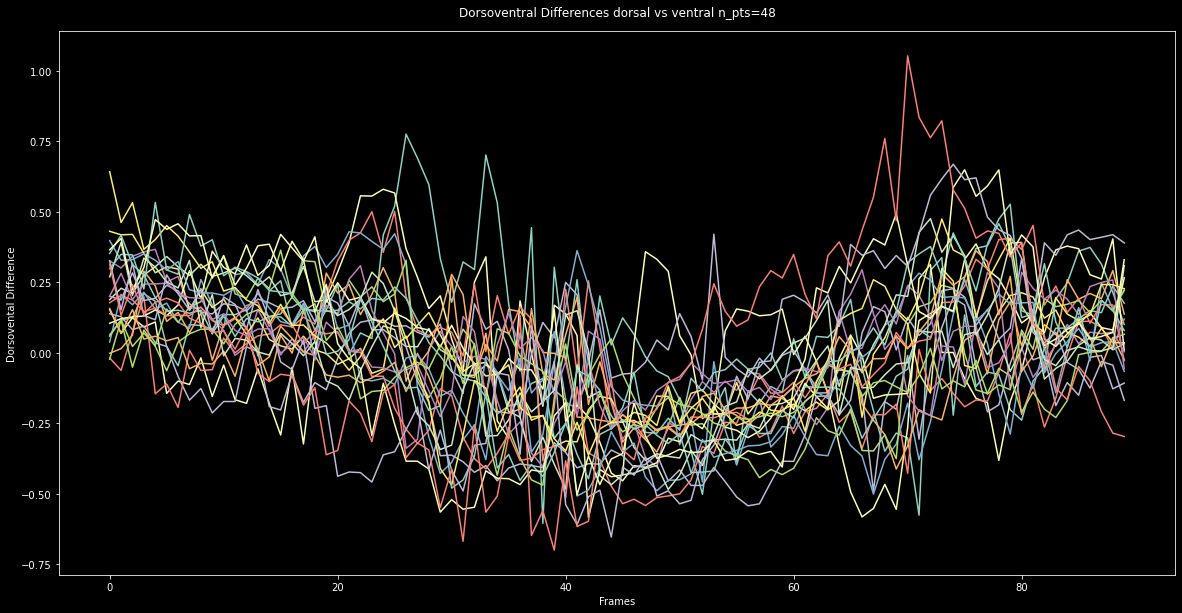

In [20]:
#Plotting the Normalized Plots
plt.figure(figsize= (20,10))
plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
plt.rcParams['axes.titlepad'] = 15 # pad is in points...
plt.plot(dorsoventral_diff)
plt.title("Dorsoventral Differences dorsal vs ventral n_pts={}".format(n_interpol))
plt.xlabel("Frames")
plt.ylabel('Dorsovental Difference')

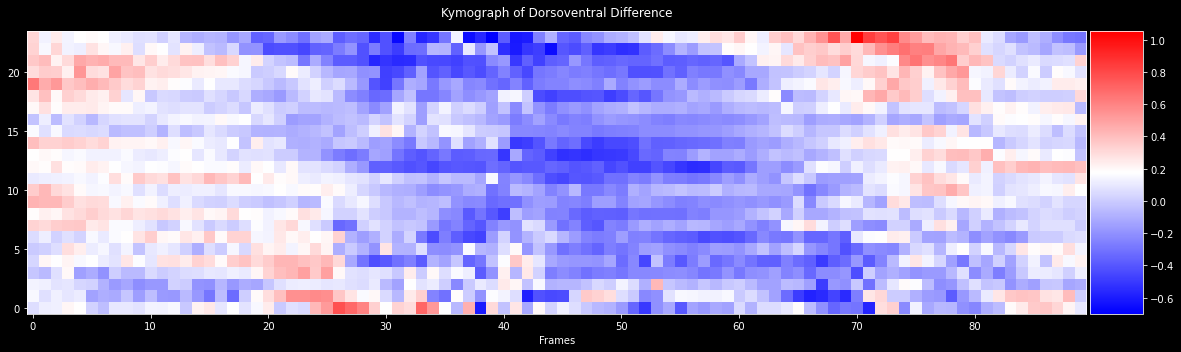

In [21]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.figure(figsize=(20,10))
plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
plt.rcParams['axes.titlepad'] = 15 # pad is in points...
ax = plt.gca()
#Head is top and tail  -49 is bottom 
im = plt.imshow(dorsoventral_diff.swapaxes(0,1), cmap='bwr',origin='lower')
plt.title("Kymograph of Dorsoventral Difference")
plt.xlabel('Frames') 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im,cax=cax)

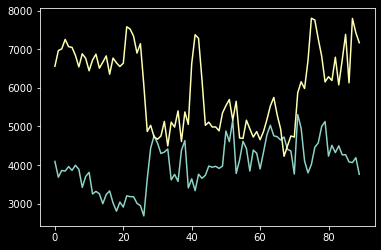

In [22]:
i=4
plt.plot(r_ventral[:,i])
plt.plot(r_dorsal[:,i])

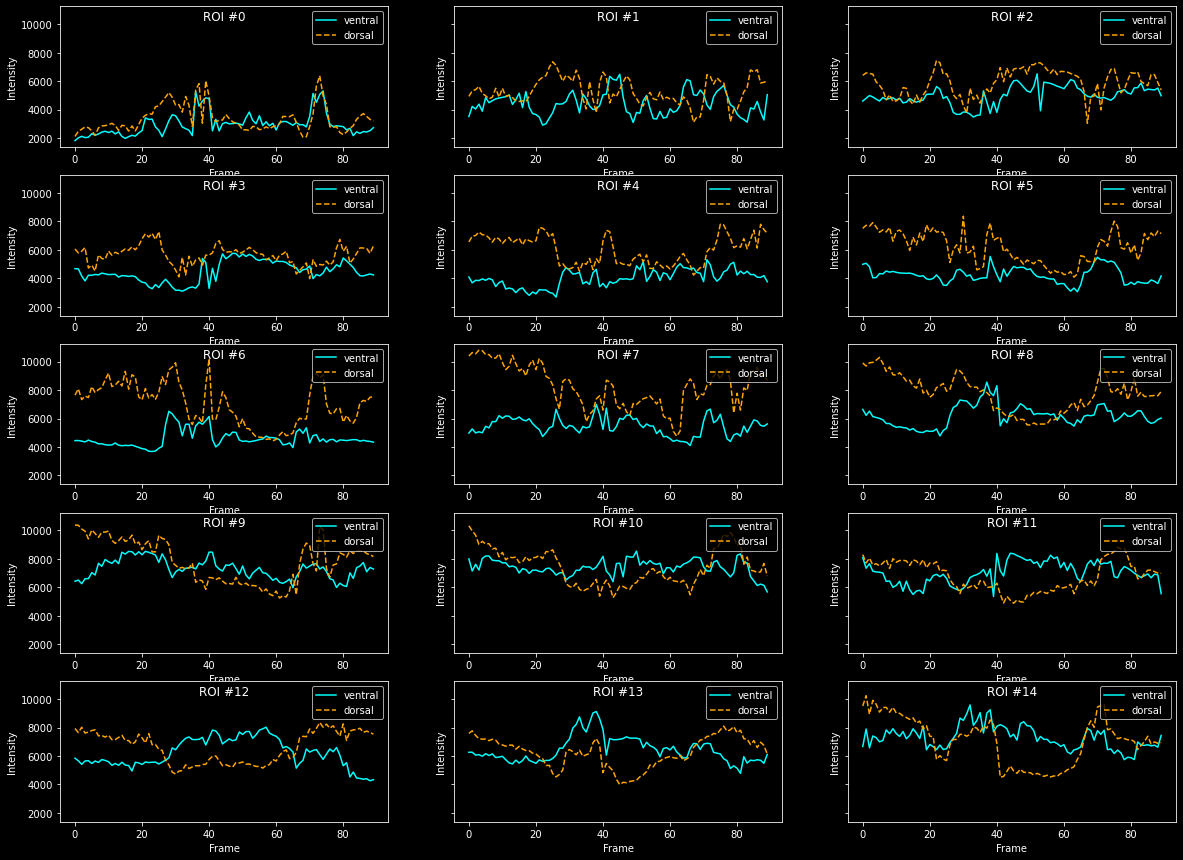

In [23]:
#Plotting Interpolated Points Intensity and Angle for different timepoints

t,r_id = r_ventral.shape

fig, axs = plt.subplots(nrows=5, ncols=3,sharey=True, figsize=(20,15))
plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
plt.rcParams['axes.titlepad'] = -14  # pad is in points...

i=0
for row in axs:
    for col in row:
        col.plot(r_ventral[:,i], label='ventral', linestyle='-',color='cyan')
        col.plot(r_dorsal[:,i], label='dorsal', linestyle='--',color='orange')
        col.legend(loc='upper right')
        col.set_title('ROI #{}'.format(i))
        col.set_ylabel('Intensity')
        col.set_xlabel('Frame')
        i+=1

In [27]:
circle_coords_R[0]
print(circle_coords_R.shape)
circle_coords_R[:5400:4,2].shape

(8640, 4, 4, 4)


(1350, 4, 4)

In [31]:
test = circle_coords_R[:150,2]

viewer.add_shapes(test, shape_type='ellipse',face_color='orange',name='dorsal')

<Shapes layer 'dorsal' at 0x1adcebba2e0>

In [ ]:
# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
#38,69,81
i=81

plane_1 = np_mip_copy[i,0]
background = rolling_ball(plane_1,radius = 10)
filtered_img2 = plane_1-background
gauss = ndi.gaussian_filter(filtered_img2,sigma=1)
th1,th2= filters.threshold_multiotsu(filtered_img2,classes =3)
th3,th4 = filters.threshold_multiotsu(gauss,classes =3)

# th1 = filters.threshold_otsu(filtered_img2)
binary_otsu = filtered_img2>th1

binary_gauss = gauss>th3
binary = filtered_img2>th1

# regions = np.digitize(gauss, bins=th_mo)
sato = filters.sato(plane_1,sigmas=range(1,15),black_ridges=False)*binary_otsu
# sato = ndi.gaussian_filter(sato,sigma=1)
# sato_not = filters.sato(filtered_img2,sigmas=range(1,5),black_ridges=True)*otsu
# sato_bin = sato >filters.threshold_otsu(sato)
sato_contour = find_contours(sato,0.001)
if len(sato_contour)>0:
    contour = sorted(sato_contour, key=lambda x: len(x))[-1]

    # Create an empty image to store the masked array
    r_mask = np.zeros_like(filtered_img2, dtype='bool')
    r_mask[np.round(contour[:, 0]).astype('int'), np.round(contour[:, 1]).astype('int')] = 1
    # Fill in the hole created by the contour boundary
    r_mask = ndi.binary_fill_holes(r_mask)
    skeleton_lee = skeletonize(r_mask, method='lee')

    skel,distance = morphology.medial_axis(r_mask,return_distance=True)
    dist_on_skel = distance*skel


#Hysteresis thresholding
thresholded = filters.apply_hysteresis_threshold(sato, 0.01, 0.03)
labeled = ndi.label(thresholded)[0]

kernel = np.ones((5,5),np.uint8)

contour_binary = thresholded
sato_fill = ndi.binary_fill_holes(contour_binary)
closing = morphology.binary_closing(sato_fill,kernel)

bg = cv2.dilate(closing.astype(np.uint8), kernel,iterations=2)
# Finding foreground area
dist_transform = cv2.distanceTransform(closing.astype(np.uint8), cv2.DIST_L2, 0)
ret, fg = cv2.threshold(dist_transform, 0.02
                        * dist_transform.max(), 255, 0)


# opening =morphology.binary_opening(closing,kernel)
# closing_fill = ndi.binary_fill_holes(opening)



# kernel = np.ones((3,3))
# hessian = filters.hessian(filtered_img2,sigmas=range(1,5),black_ridges=True)
# hess_open = morphology.opening(hessian,kernel)
# hess_fill = morphology.flood_fill(hess_open,(1,1),5,connectivity=1)

fig, ax = plt.subplots(3, 4, figsize=(30, 20), sharey=True)
ax[0, 0].imshow(plane_1, cmap=plt.cm.gray)
ax[0, 0].set_title('a) Raw')

ax[0, 1].imshow(filtered_img2, cmap=plt.cm.gray)
ax[0, 1].set_title('a) sub background')

ax[0, 2].imshow(binary_gauss, cmap=plt.cm.gray)
ax[0, 2].set_title('binary_gauss')

ax[0, 3].imshow(binary, cmap=plt.cm.gray)
ax[0, 3].set_title('binary otsu')

ax[1, 0].imshow(sato, cmap=plt.cm.gray)
ax[1, 0].set_title('Sato')

ax[1, 1].imshow(filtered_img2, cmap='magma')
ax[1, 1].plot(contour[:, 1], contour[:, 0], linewidth=2)
ax[1, 1].set_title('Contour')

ax[1, 2].imshow(color.label2rgb(labeled,plane_1))
ax[1, 2].set_title('hysteresis threshold')

# ax[1, 3].imshow(plane_1,alpha=0.5,cmap=plt.cm.gray)
# ax[1, 3].imshow(skeleton_lee,'jet',alpha=0.5)
ax[1, 3].imshow(sato_fill)
ax[1, 3].set_title('filled contour and skeletonization')

ax[2, 0].imshow(closing)
ax[2, 0].set_title('closing')

ax[2, 1].imshow(fg, cmap='magma')
ax[2, 1].set_title('clossing')

ax[2, 2].imshow(bg, cmap='magma')
ax[2, 2].set_title('Hessian')

# ax[2, 3].imshow(hessian, cmap='magma')
# ax[2, 3].set_title('Hessian')


## HEssian 

# ax[2, 0].imshow(hessian, cmap='magma')
# ax[2, 0].set_title('Hessian')

# ax[2, 1].imshow(hess_open, cmap='magma')
# ax[2, 1].set_title('Hessian')

# ax[2, 2].imshow(hess_fill, cmap='magma')
# ax[2, 2].set_title('Hessian')

# ax[2, 3].imshow(hessian, cmap='magma')
# ax[2, 3].set_title('Hessian')


<Image layer 'regions' at 0x2a3e46e9a00>

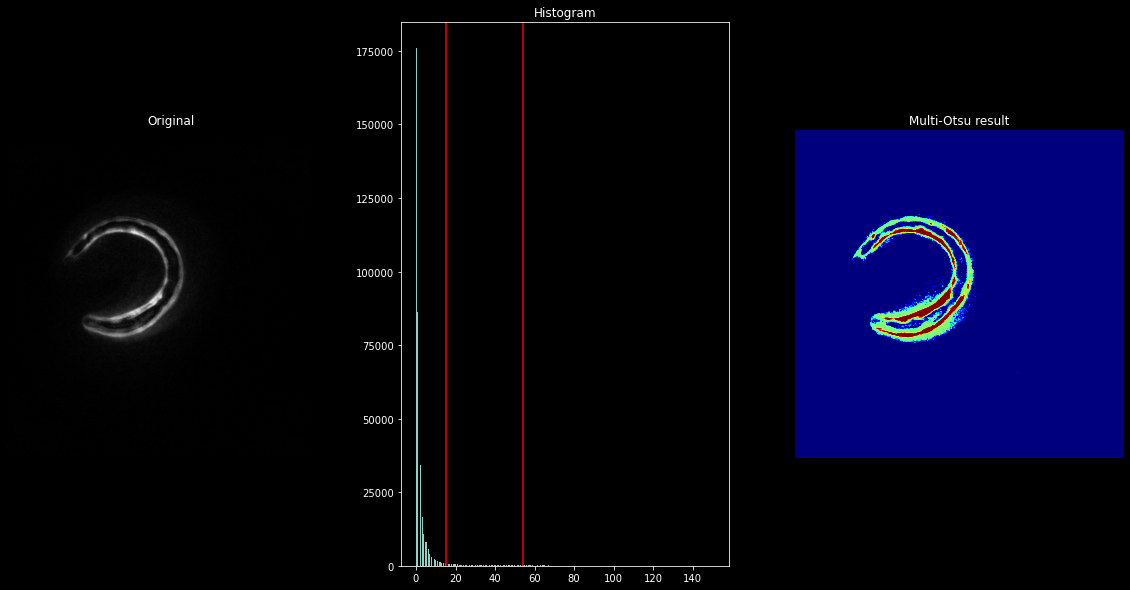

In [ ]:
#Playing with MultiOtsu
from skimage.filters import threshold_multiotsu
# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
i=10
plane_1 = np_mip_copy[i,0]
background = rolling_ball(plane_1,radius = 10)
filtered_img2 = plane_1-background
thresholds = threshold_multiotsu(filtered_img2,classes =3)

# Using the threshold values, we generate the three regions.
regions = np.digitize(filtered_img2, bins=thresholds)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))

# Plotting the original image.
ax[0].imshow(filtered_img2, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].hist(filtered_img2.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')
# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')
viewer.add_image(regions,colormap='hsv',opacity=0.5)

In [ ]:
#Exploration #2 Adaptive Thresholds
# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
#38,69,81
i=32

plane_1 = np_mip_copy[i,0]
plane_1 = wo.im_bit_convert(plane_1,bit=8, norm=True)
gauss = ndi.gaussian_filter(plane_1,sigma=6)


otsu = filters.threshold_otsu(gauss)
binary = gauss> otsu
thresh = binary.astype(np.uint8)
dilation = morphology.binary_dilation(binary)
fill = morphology.area_closing(dilation,area_threshold=100,connectivity=1)
# closing = morphology.binary_closing(dilation)
thin = morphology.thin(fill)

thresh_contour = find_contours(thresh,0.5)
contour = sorted(thresh_contour, key=lambda x: len(x))[-1]
# Create an empty image to store the masked array
r_mask = np.zeros_like(plane_1, dtype='bool')
r_mask[np.round(contour[:, 0]).astype('int'), np.round(contour[:, 1]).astype('int')] = 1
# Fill in the hole created by the contour boundary
r_mask = ndi.binary_fill_holes(r_mask)
skeleton_lee = skeletonize(r_mask, method='lee')

skel,distance = morphology.medial_axis(r_mask,return_distance=True)
dist_on_skel = distance*skel


background = rolling_ball(gauss,radius= 5)
filtered_img2 = gauss-background
otsu2 = filters.threshold_otsu(filtered_img2)
binary2= filtered_img2> otsu2
thresh2 = binary2.astype(np.uint8)
dilation2=morphology.binary_dilation(thresh2)
thin2 = morphology.thin(dilation2)

fig, ax = plt.subplots(3, 4, figsize=(30, 20), sharey=True)
ax[0, 0].imshow(plane_1, cmap=plt.cm.gray)
ax[0, 0].set_title('a) Raw')

ax[0, 1].imshow(filtered_img2, cmap=plt.cm.gray)
ax[0, 1].set_title('a) sub background')

ax[0, 2].imshow(gauss, cmap=plt.cm.gray)
ax[0, 2].set_title('a) gauss')

ax[0, 3].imshow(thresh, cmap=plt.cm.gray)
ax[0, 3].set_title('binary multiotsu 3')

ax[1, 0].imshow(plane_1,alpha=0.5,cmap=plt.cm.gray)
ax[1, 0].imshow(skeleton_lee,'jet',alpha=0.5)
ax[1, 0].set_title('Skeleton Lee')

ax[1, 1].imshow(plane_1, alpha=0.5)
ax[1, 1].imshow(thin, cmap='magma',alpha=0.5)
ax[1, 1].set_title('Thinning')

ax[1, 2].imshow(thin, cmap='Purples',alpha=0.5)
ax[1, 2].imshow(skeleton_lee, cmap='Greens',alpha=0.5)
ax[1, 2].imshow(dist_on_skel, cmap='Reds',alpha=0.5)
ax[1, 2].set_title('comparison')

ax[1, 3].imshow(filtered_img2, cmap='magma')
ax[1, 3].plot(contour[:, 1], contour[:, 0], linewidth=2)
ax[1, 3].set_title('Contour')

ax[2, 0].imshow(dilation,cmap=plt.cm.gray)
ax[2, 0].set_title('Skeleton Lee')

ax[2, 1].imshow(fill,cmap=plt.cm.gray)
ax[2, 1].set_title('binary2')

ax[2, 2].imshow(dilation2,cmap=plt.cm.gray)
ax[2, 2].set_title('dilation2')

ax[2, 3].imshow(plane_1, alpha=0.5)
ax[2, 3].imshow(thin2, cmap='magma',alpha=0.5)
ax[2, 3].set_title('Thinning')


Text(0.5, 1.0, 'Hessian')

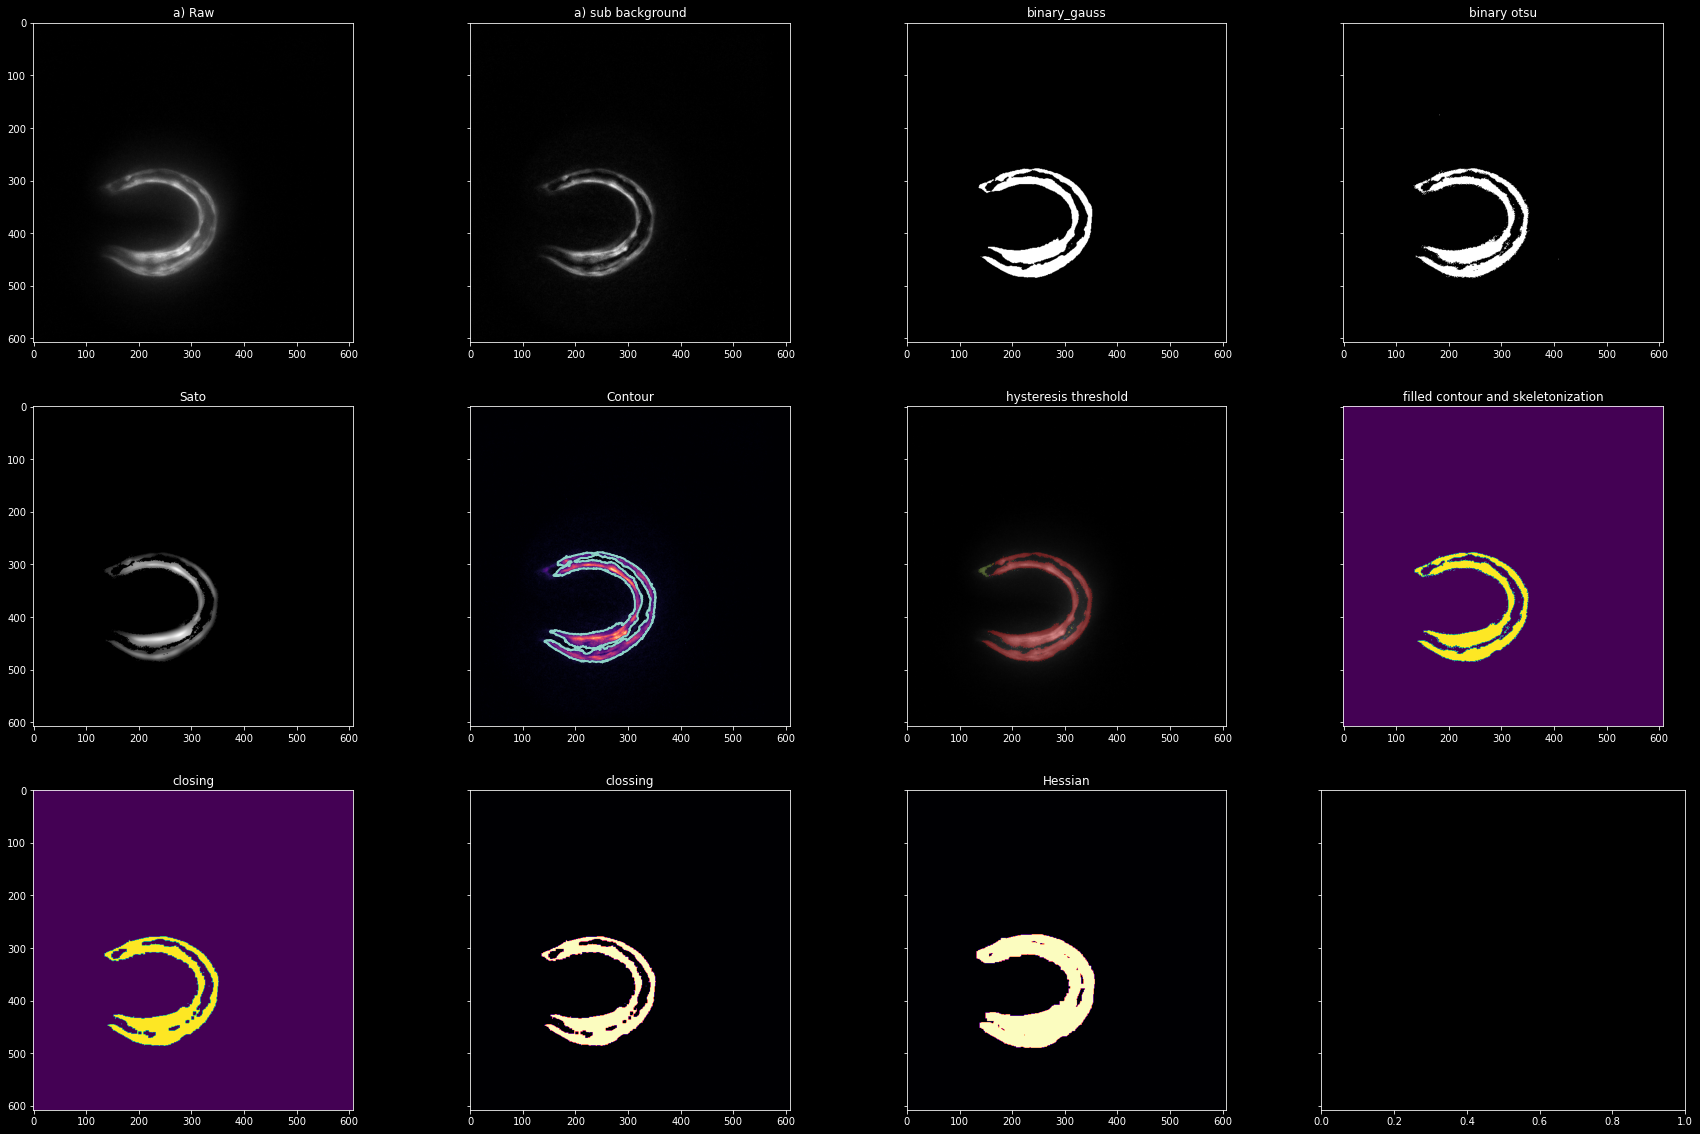

In [ ]:
#Exploration #2 Adaptive Thresholds
# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
#38,69,81
i=32

plane_1 = np_mip_copy[i,0]
plane_1 = wo.im_bit_convert(plane_1,bit=8, norm=True)
gauss = ndi.gaussian_filter(plane_1,sigma=6)


otsu = filters.threshold_otsu(gauss)
binary = gauss> otsu
thresh = binary.astype(np.uint8)
dilation = morphology.binary_dilation(binary)
fill = morphology.area_closing(dilation,area_threshold=100,connectivity=1)
# closing = morphology.binary_closing(dilation)
thin = morphology.thin(fill)

thresh_contour = find_contours(thresh,0.5)
contour = sorted(thresh_contour, key=lambda x: len(x))[-1]
# Create an empty image to store the masked array
r_mask = np.zeros_like(plane_1, dtype='bool')
r_mask[np.round(contour[:, 0]).astype('int'), np.round(contour[:, 1]).astype('int')] = 1
# Fill in the hole created by the contour boundary
r_mask = ndi.binary_fill_holes(r_mask)
skeleton_lee = skeletonize(r_mask, method='lee')

skel,distance = morphology.medial_axis(r_mask,return_distance=True)
dist_on_skel = distance*skel


background = rolling_ball(gauss,radius= 5)
filtered_img2 = gauss-background
otsu2 = filters.threshold_otsu(filtered_img2)
binary2= filtered_img2> otsu2
thresh2 = binary2.astype(np.uint8)
dilation2=morphology.binary_dilation(thresh2)
thin2 = morphology.thin(dilation2)

fig, ax = plt.subplots(3, 4, figsize=(30, 20), sharey=True)
ax[0, 0].imshow(plane_1, cmap=plt.cm.gray)
ax[0, 0].set_title('a) Raw')

ax[0, 1].imshow(filtered_img2, cmap=plt.cm.gray)
ax[0, 1].set_title('a) sub background')

ax[0, 2].imshow(gauss, cmap=plt.cm.gray)
ax[0, 2].set_title('a) gauss')

ax[0, 3].imshow(thresh, cmap=plt.cm.gray)
ax[0, 3].set_title('binary multiotsu 3')

ax[1, 0].imshow(plane_1,alpha=0.5,cmap=plt.cm.gray)
ax[1, 0].imshow(skeleton_lee,'jet',alpha=0.5)
ax[1, 0].set_title('Skeleton Lee')

ax[1, 1].imshow(plane_1, alpha=0.5)
ax[1, 1].imshow(thin, cmap='magma',alpha=0.5)
ax[1, 1].set_title('Thinning')

ax[1, 2].imshow(thin, cmap='Purples',alpha=0.5)
ax[1, 2].imshow(skeleton_lee, cmap='Greens',alpha=0.5)
ax[1, 2].imshow(dist_on_skel, cmap='Reds',alpha=0.5)
ax[1, 2].set_title('comparison')

ax[1, 3].imshow(filtered_img2, cmap='magma')
ax[1, 3].plot(contour[:, 1], contour[:, 0], linewidth=2)
ax[1, 3].set_title('Contour')

ax[2, 0].imshow(dilation,cmap=plt.cm.gray)
ax[2, 0].set_title('Skeleton Lee')

ax[2, 1].imshow(fill,cmap=plt.cm.gray)
ax[2, 1].set_title('binary2')

ax[2, 2].imshow(dilation2,cmap=plt.cm.gray)
ax[2, 2].set_title('dilation2')

ax[2, 3].imshow(plane_1, alpha=0.5)
ax[2, 3].imshow(thin2, cmap='magma',alpha=0.5)
ax[2, 3].set_title('Thinning')
